In [10]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [17]:
class GP(object):
    @classmethod
    def kernel_bell_shape(cls, a, b, delta=1.0):
        #return np.exp(-1/2.0 * np.power(x - y, 2) / delta)
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)  
        return np.exp(-.5 * sqdist)
   
    @classmethod
    def kernel_laplacian(cls, x, y, delta=1):
        return np.exp(-1/2.0 * np.abs(x - y) / delta)
    
    @classmethod
    def generate_kernel(cls, kernel, delta=1):
        def wrapper(*args, **kwargs):
            kwargs.update({"delta": delta})
            return kernel(*args, **kwargs)
        return wrapper
        
    def __init__(self, x, y, cov_f=None, R=0):
        super().__init__()
        self.x = x
        self.y = y
        self.N = len(self.x)
        self.R = R
        
        self.sigma = []
        self.mean = []
        self.cov_f = cov_f if cov_f else self.kernel_bell_shape
        self.setup_sigma()

    @classmethod
    def calculate_sigma(cls, x, cov_f, R=0):
        '''N = len(x)
        sigma = np.ones((N, N))
        for i in range(N):
            for j in range(i+1, N):
                cov = cov_f(x[i], x[j])
                sigma[i][j] = cov
                sigma[j][i] = cov
        
        sigma = sigma + R * np.eye(N)'''
        print (x.reshape(-1,1))
        return cov_f(x.reshape(-1,1),x.reshape(-1,1))
    
    def setup_sigma(self):
        self.sigma = self.calculate_sigma(self.x, self.cov_f, self.R)

    def predict(self, x):
        cov = 1 + self.R * self.cov_f(x, x)
        sigma_1_2 = np.zeros((self.N, 1))
        for i in range(self.N):
            sigma_1_2[i] = self.cov_f(self.x[i], x)

        # SIGMA_1_2 * SIGMA_1_1.I * (Y.T -M)
        # M IS ZERO
        m_expt = (sigma_1_2.T * np.mat(self.sigma).I) * np.mat(self.y).T
        # sigma_expt = cov - (sigma_1_2.T * np.mat(self.sigma).I) * sigma_1_2
        sigma_expt = cov + self.R - (sigma_1_2.T * np.mat(self.sigma).I) * sigma_1_2
        return m_expt, sigma_expt
    
    @staticmethod
    def get_probability(sigma, y, R):
        multiplier = np.power(np.linalg.det(2 * np.pi * sigma), -0.5)
        return multiplier * np.exp(
            (-0.5) * (np.mat(y) * np.dot(np.mat(sigma).I, y).T))

    def optimize(self, R_list, B_list):
        
        def cov_f_proxy(delta, f):
            def wrapper(*args, **kwargs):
                kwargs.update({"delta": delta})
                return f(*args, **kwargs)
            return wrapper
        
        best = (0, 0, 0)
        history = []
        for r in R_list:
            best_beta = (0, 0)
            for b in B_list:
                sigma = gaus.calculate_sigma(self.x, cov_f_proxy(b, self.cov_f), r)
                marginal = b* float(self.get_probability(sigma, self.y, r))
                if marginal > best_beta[0]:
                    best_beta = (marginal, b)
            history.append((best_beta[0], r, best_beta[1]))
        return sorted(history)[-1], np.mat(history)


## Setting up a gaussian processor

In [18]:
x = np.array([-2, -1, 0, 3.5, 4]);
y = np.array([4.1, 0.9, 2, 12.3, 15.8])
gaus = GP(x, y)

x_guess = np.linspace(-5, 16, 400)
y_pred = np.vectorize(gaus.predict)(x_guess)

plt.scatter(x, y, c="black")
plt.plot(x_guess, y_pred[0], c="b")
plt.plot(x_guess, y_pred[0] - np.sqrt(y_pred[1]) * 3, "r:")
plt.plot(x_guess, y_pred[0] + np.sqrt(y_pred[1]) * 3, "r:")

[[-2. ]
 [-1. ]
 [ 0. ]
 [ 3.5]
 [ 4. ]]


AxisError: axis 1 is out of bounds for array of dimension 0

In [4]:
def create_case(kernel, R=0):
    x = np.array([-2, -1, 0, 3.5, 4]);
    y = np.array([4.1, 0.9, 2, 12.3, 15.8])
    gaus = GP(x, y, kernel, R=R)

    x_guess = np.linspace(-4, 6, 400)
    y_pred = np.vectorize(gaus.predict)(x_guess)
    
    plt.scatter(x, y, c="black")
    plt.plot(x_guess, y_pred[0], c="b")
    plt.plot(x_guess, y_pred[0] - np.sqrt(y_pred[1]) * 3, "r:")
    plt.plot(x_guess, y_pred[0] + np.sqrt(y_pred[1]) * 3, "r:")

## The effects of regularization parameter

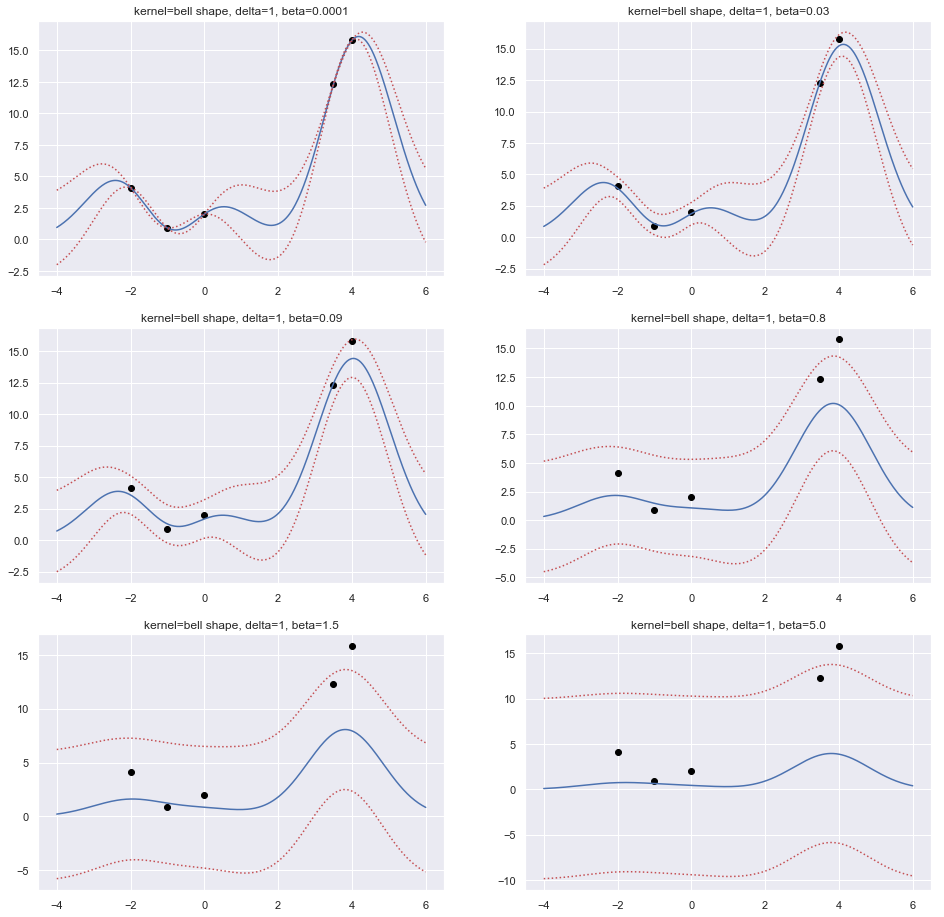

In [5]:
plt.figure(figsize=(16, 16))
for i, r in enumerate([0.0001, 0.03, 0.09, 0.8, 1.5, 5.0]):
    plt.subplot("32{}".format(i+1))
    plt.title("kernel={}, delta={}, beta={}".format("bell shape", 1, r))
    create_case(
        GP.generate_kernel(GP.kernel_bell_shape, delta=1), R=r)

## The effects of delta

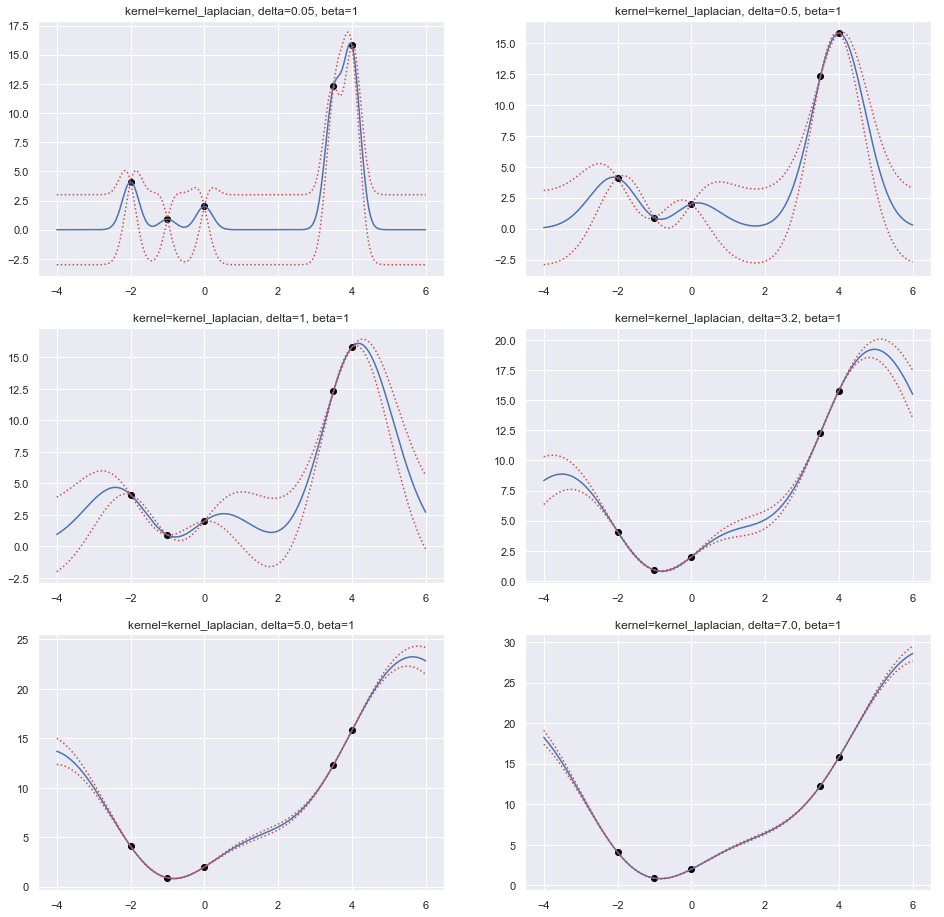

In [6]:
plt.figure(figsize=(16, 16))
for i, d in enumerate([0.05, 0.5, 1, 3.2, 5.0, 7.0]):
    plt.subplot("32{}".format(i+1))
    plt.title("kernel={}, delta={}, beta={}".format("kernel_laplacian", d, 1))
    create_case(
        GP.generate_kernel(GP.kernel_bell_shape, delta=d), R=0)

## Finding the optimal parameters

best parameters (probability, r, b):  (1.5498274313157562e-19, 1.0, 10.0)


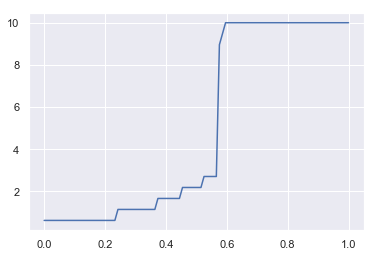

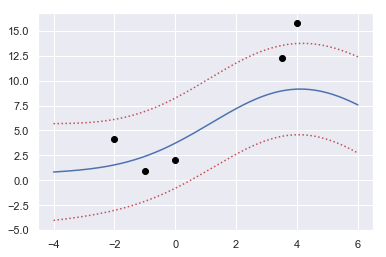

In [7]:
x = np.array([-2, -1, 3.5]);
y = np.array([4.1, 0.9, 12.3])
gaus = GP(x, y)
R_list = np.linspace(0.0, 1, 100)
B_list = np.linspace(0.1, 10, 20)
best_params, history = gaus.optimize(R_list, B_list)
plt.plot(history[:,1], history[:,2])
print("best parameters (probability, r, b): ", best_params)
plt.show()
create_case(
        GP.generate_kernel(GP.kernel_bell_shape, delta=10), R=1.0)